# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import pickle
import requests

from IPython.display import display, HTML
from flask import Flask, request, Response
from scipy import stats
from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 0.1 Helper Functions

In [75]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML("<style>.container { width:95% !important; }</style>"))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set
    

    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))



def mean_absolute_percentage_error( y, yhat ):
    return np.mean(np.abs( ( y - yhat ) / y ) )


def ml_error ( model_name, y, yhat):
    mae = mean_absolute_error (y, yhat )
    mape = mean_absolute_percentage_error (y, yhat )
    rmse = np.sqrt( mean_squared_error (y, yhat) )
    
    return pd.DataFrame ( { 'Model Name': model_name,'MAE': mae,'MAPE': mape,'RMSE': rmse}, index=[0])



def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [76]:
jupyter_settings()

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
820584,730,3,2013-06-26,8720,1070,1,0,0,1,c,a,1190.0,9.0,2013.0,0,NaN,NaN,NaN
67647,748,1,2015-06-01,8677,596,1,1,0,0,d,a,2380.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
106054,130,1,2015-04-27,7479,724,1,1,0,0,c,a,900.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
473811,722,6,2014-05-03,9807,1743,1,0,0,0,a,a,50.0,NaN,NaN,0,NaN,NaN,NaN
970778,399,1,2013-02-11,4941,571,1,0,0,1,a,a,5360.0,9.0,2012.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


# 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
        'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
        'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols))

df1.columns = cols_new

## 1.2 Data Dimension

In [6]:
df1.shape

(1017209, 18)

## 1.3 Data Types

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [7]:
#alterando a colunda data de object para tipo data

df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [63]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [8]:
#competition_distance  

df1['competition_distance'] = (df1['competition_distance'].
                               apply(lambda x: 200000.0 if math.isnan(x) else (x)))


#competition_open_since_month
df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].
                                                 month if math.isnan(x['competition_open_since_month'])
                                                 else x['competition_open_since_month'], axis=1))

#competition_open_since_year
df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].
                                                 year if math.isnan(x['competition_open_since_year'])
                                                 else x['competition_open_since_year'], axis=1))

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                               else x['promo2_since_week'], axis=1)


#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                               else x['promo2_since_year'], axis=1)

#promo_interval

month_map = { 1: 'Jan', 2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May', 6: 'Jun',  
             7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct',  11: 'Nov',  12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = (df1[['promo_interval', 'month_map']].
                   apply(lambda x: 0 if x['promo_interval'] == 0 
                         else 1 if x['month_map'] in x['promo_interval'].split(',') 
                         else 0, axis=1))


In [65]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [66]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Change Types

In [9]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'datetime64[ns]', 'float64'])

###  1.7.1 Numerical Attributes

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T



# Dispersion - std, min, max, ran, skew, curtusis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()

m.columns = ( [ 'features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ] )
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.1 Categorical Attributes

In [70]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

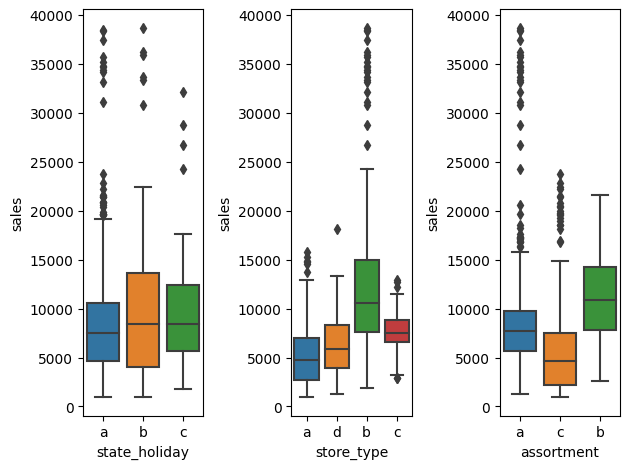

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]


plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.tight_layout();

# 2.0 Featuring Engineering

In [10]:
df2 = df1.copy()

## 2.1 Lista de Hipóteses

### H1. Lojas com maior sortimentos deveriam vender mais
### H2. Lojas com competidores mais próximos deveriam vender menos.
### H3. Lojas com competidores à mais tempo deveriam vendem mais.
### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
### H5. Lojas com mais dias de promoção deveriam vender mais.
### H6. Lojas com mais promoções consecutivas deveriam vender mais.
### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
### H8. Lojas deveriam vender mais ao longo dos anos.
### H9. Lojas deveriam vender mais no segundo semestre do ano.
### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
### H11. Lojas deveriam vender menos aos finais de semana
### H12. Lojas deveriam vender menos durante os feriados escolares


## 2.2 Feature Engineering

In [11]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = (df2.apply(lambda x: datetime.datetime
                                      (year=x['competition_open_since_year'],
                                       month=x['competition_open_since_month'],
                                       day=1), axis=1))


#df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int))

df2['competition_time_month'] = (df2['date'] - df2['competition_since']).apply(lambda x: (x.days)/30).astype(int)




# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = (df2['promo_since'].
                      apply(lambda x: datetime.datetime.
                            strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)))


df2['promo_time_week'] = df2['competition_time_month'] = (((df2['date'] - df2['promo_since']) / 7).
                                 apply(lambda x: x.days).astype(int))



# assortment



df2['assortment'] = (df2['assortment'].
                     apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended'))

# state_holiday

df2['state_holiday'] = (df2['state_holiday'].
                     apply(lambda x: 'public_holiday' if x == 'a' 
                           else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' 
                           else 'regular'))


df2.head().T


,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular,regular,regular,regular,regular
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [12]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [13]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0 )]

## 3.2 Seleção das Colunas

In [14]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados

In [15]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

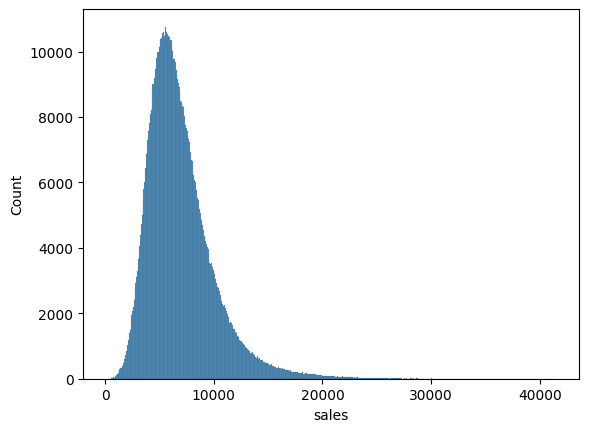

In [25]:
sns.histplot( df4['sales']);

### 4.1.2 Numerical Variable

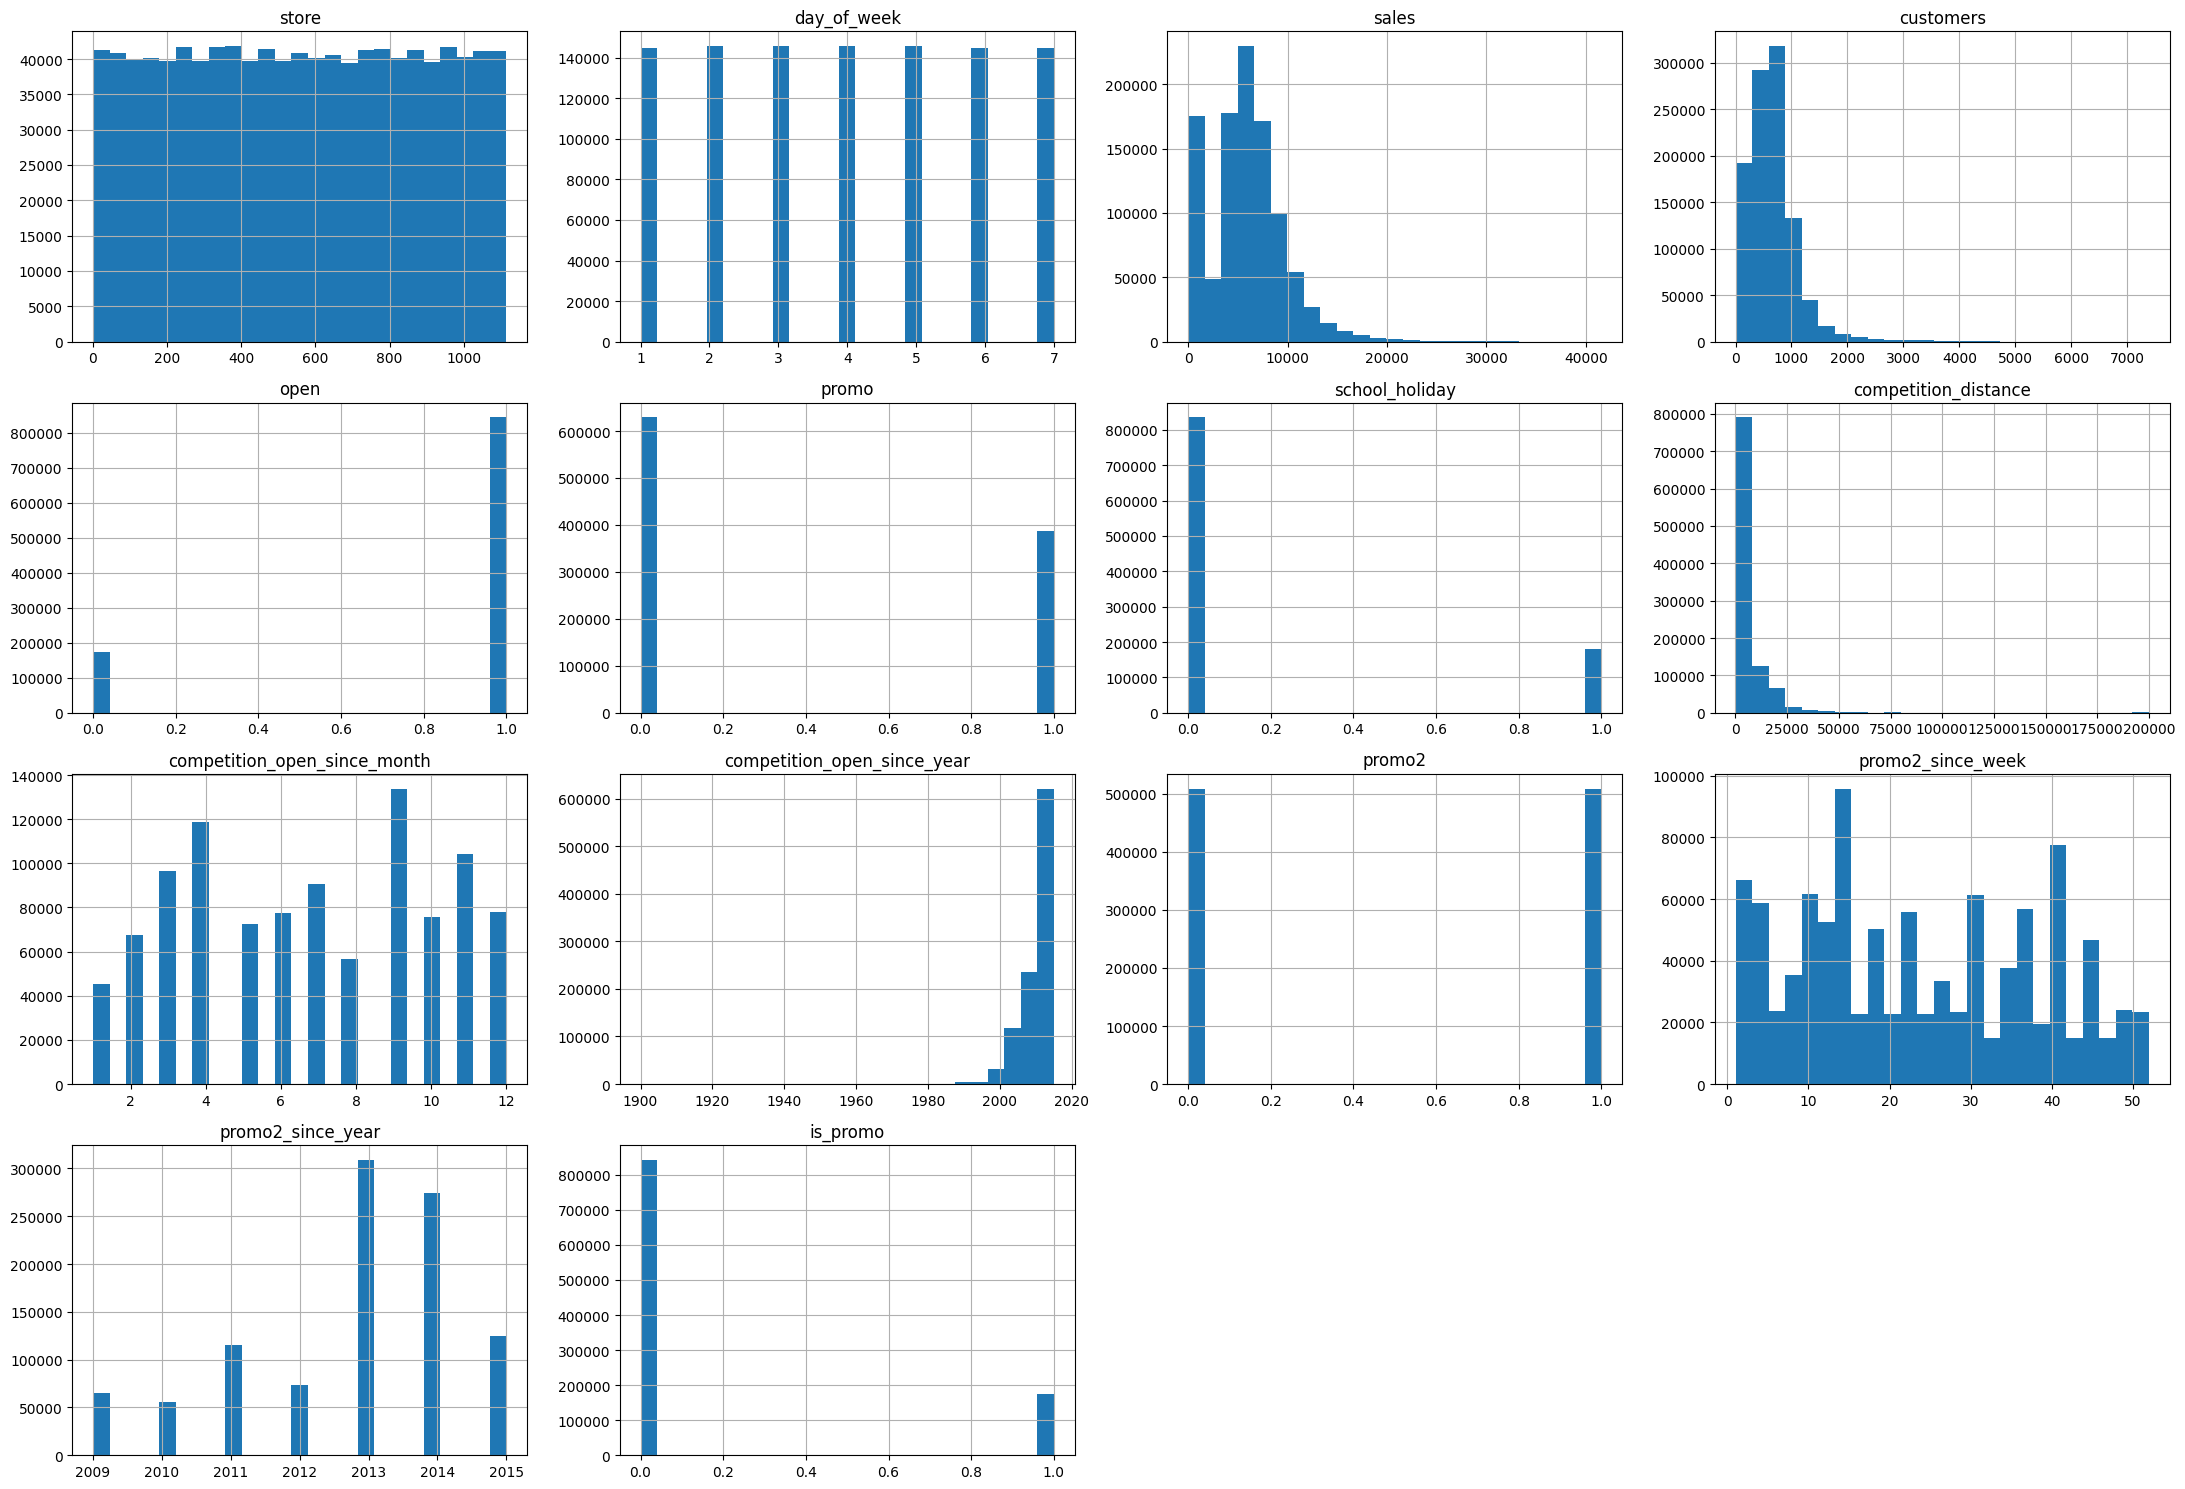

In [28]:
num_attributes.hist(bins=25, figsize=(22,15))
plt.tight_layout();

### 4.1.3 Categorical Variable¶

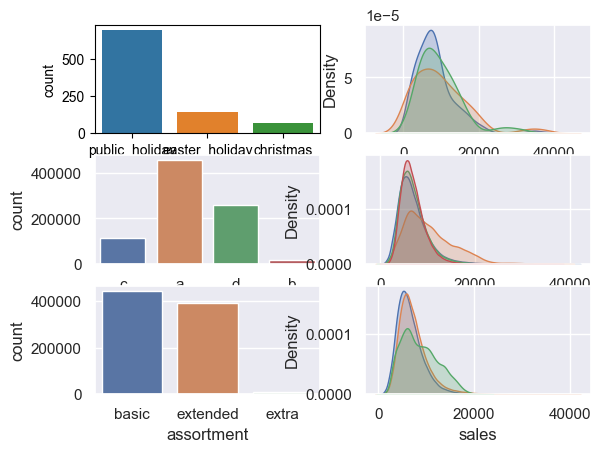

In [29]:
#state_holiday

plt.subplot(3, 2, 1)
aux4 = df4[df4['state_holiday'] != 'regular']
sns.countplot( data = aux4, x='state_holiday' )
sns.set(rc={'figure.figsize':(8.8,8.27)})


plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})




#store_type

plt.subplot(3, 2, 3)
sns.countplot( data = df4, x='store_type' )
sns.set(rc={'figure.figsize':(8.8,8.27)})


plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})


#assortment

plt.subplot(3, 2, 5)
sns.countplot( data = df4, x='assortment' )
sns.set(rc={'figure.figsize':(8.8,8.27)})


plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais

- **FALSA** Lojas com maior sortimento vendem menos

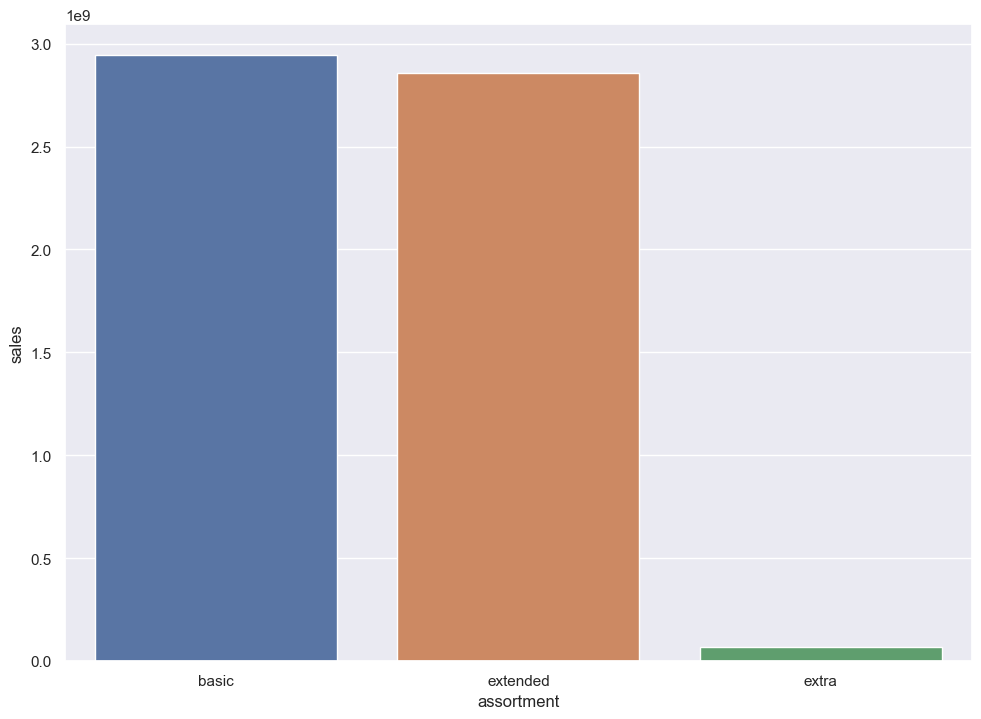

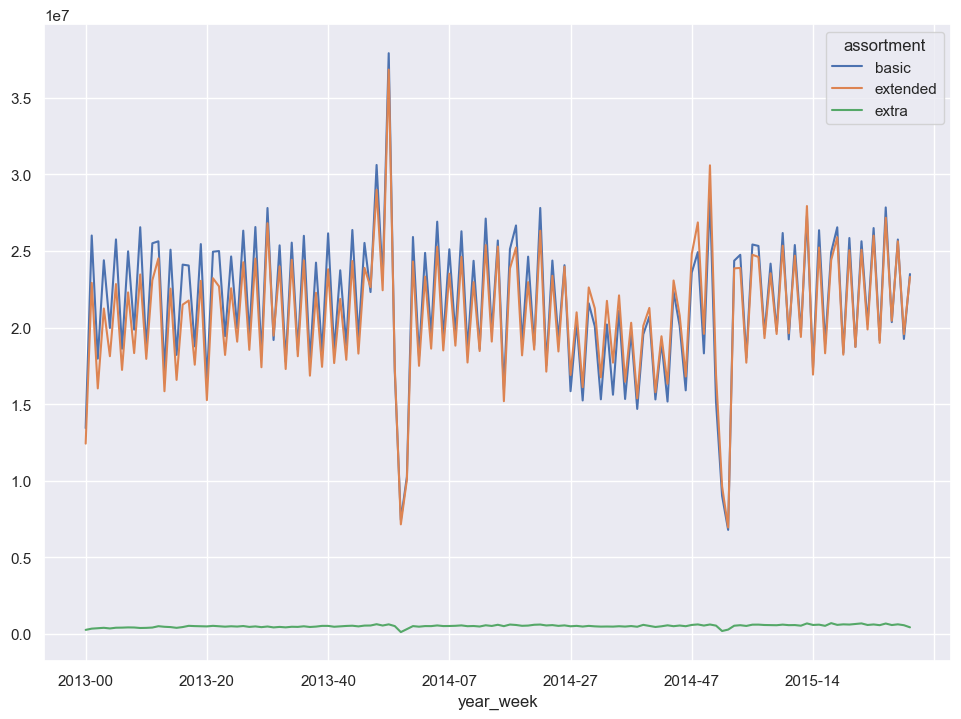

In [31]:
df_h1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y= 'sales', data = df_h1);

df_h1_2 = df4[['year_week' ,'assortment', 'sales']].groupby(['assortment', 'year_week']).sum().reset_index()
df_h1_2.pivot(index= 'year_week', columns= 'assortment' , values= 'sales' ).plot();




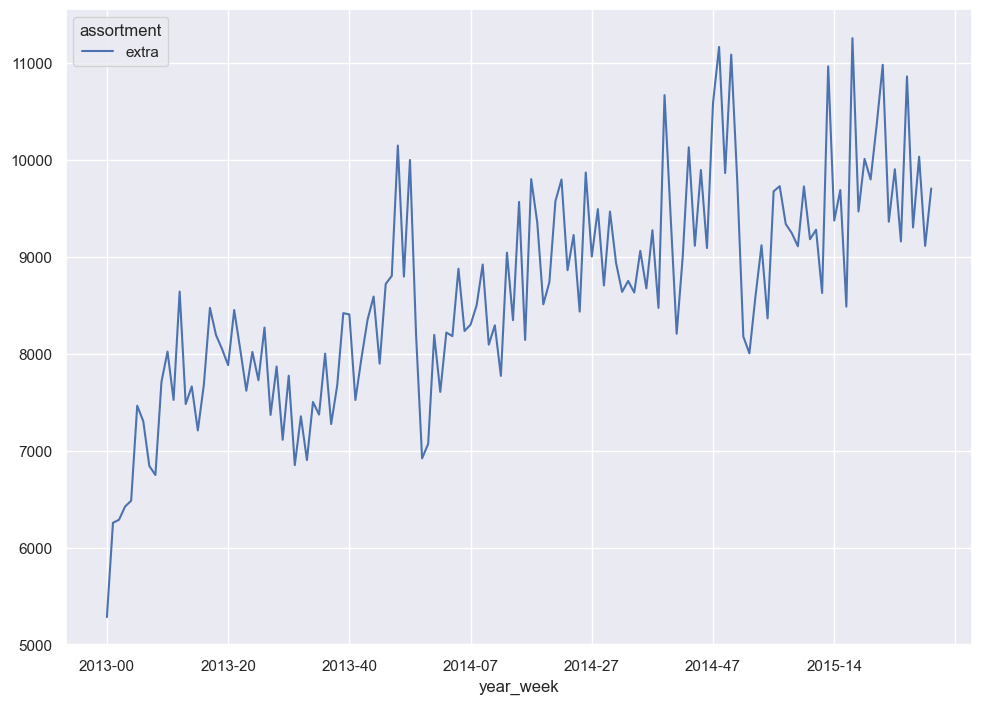

In [32]:
df_h1_3 = df4[df4['assortment'] == 'extra'].reset_index()
df_h1_3.pivot_table(index= 'year_week', columns= 'assortment' , values= 'sales' ).plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.

- **FALSA**: Lojas com competidores próximos vendem mais

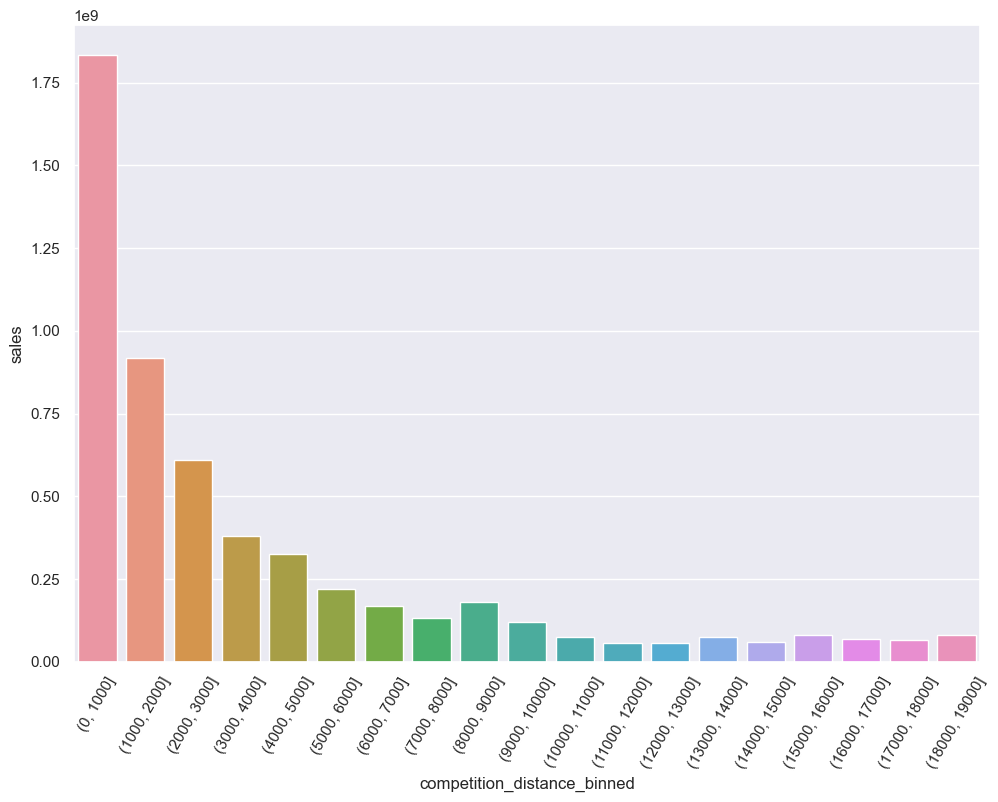

In [33]:
h2 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


bins = list(np.arange(0, 20000, 1000))
h2['competition_distance_binned'] = pd.cut(h2['competition_distance'], bins=bins) 
h2_2 = h2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned', y='sales', data=h2_2)
plt.xticks(rotation=60);

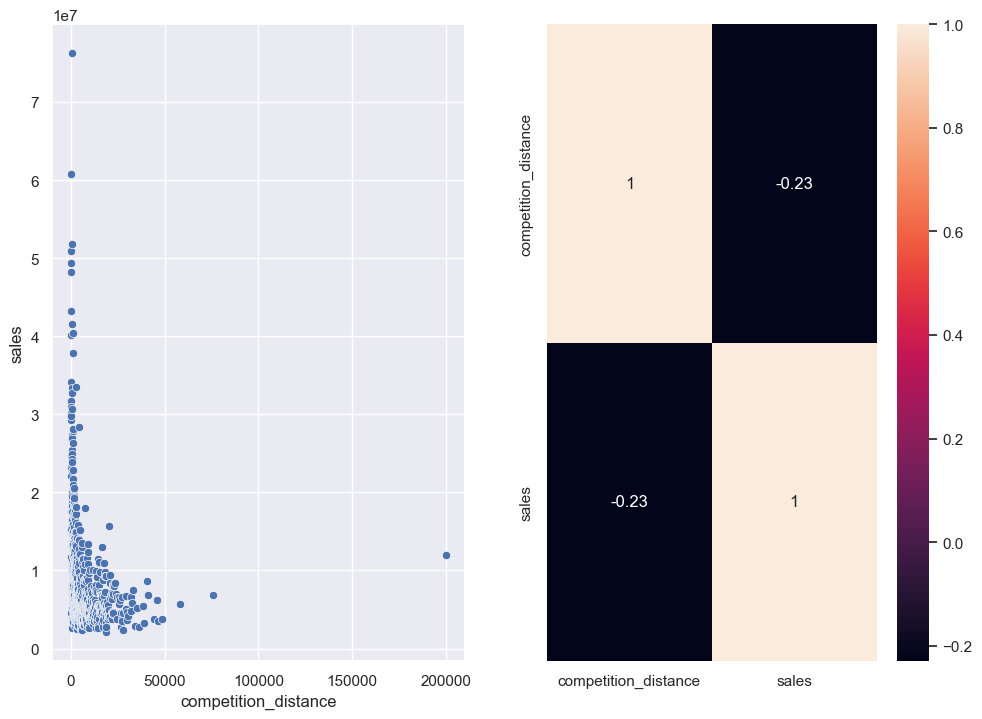

In [34]:
plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=h2)

plt.subplot(1, 2, 2)
corr = h2[['competition_distance', 'sales']]
corr = corr.corr()
sns.heatmap(corr, annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.

- ***FALSA:*** Lojas com competidores a mais tempo vendem menos, a venda é maior quanto mais recente é a competição


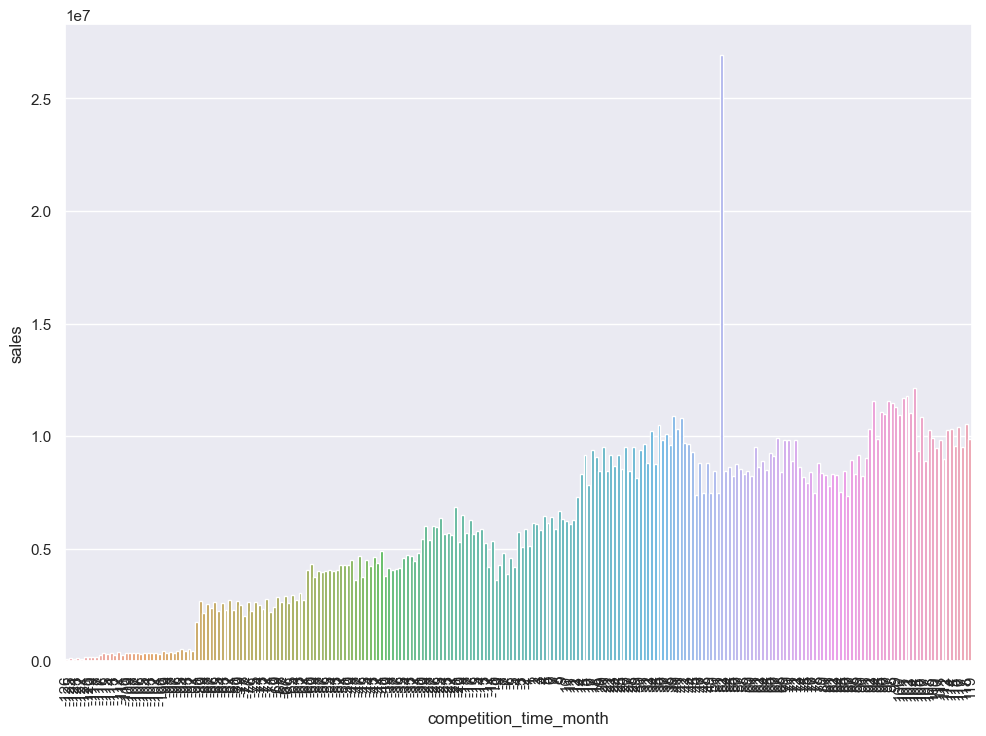

In [33]:
h3 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
h3_1 = h3[(h3['competition_time_month'] < 120) & (h3['competition_time_month'] != 0)]
sns.barplot(data=h3_1, x='competition_time_month', y='sales')
plt.xticks(rotation=90);

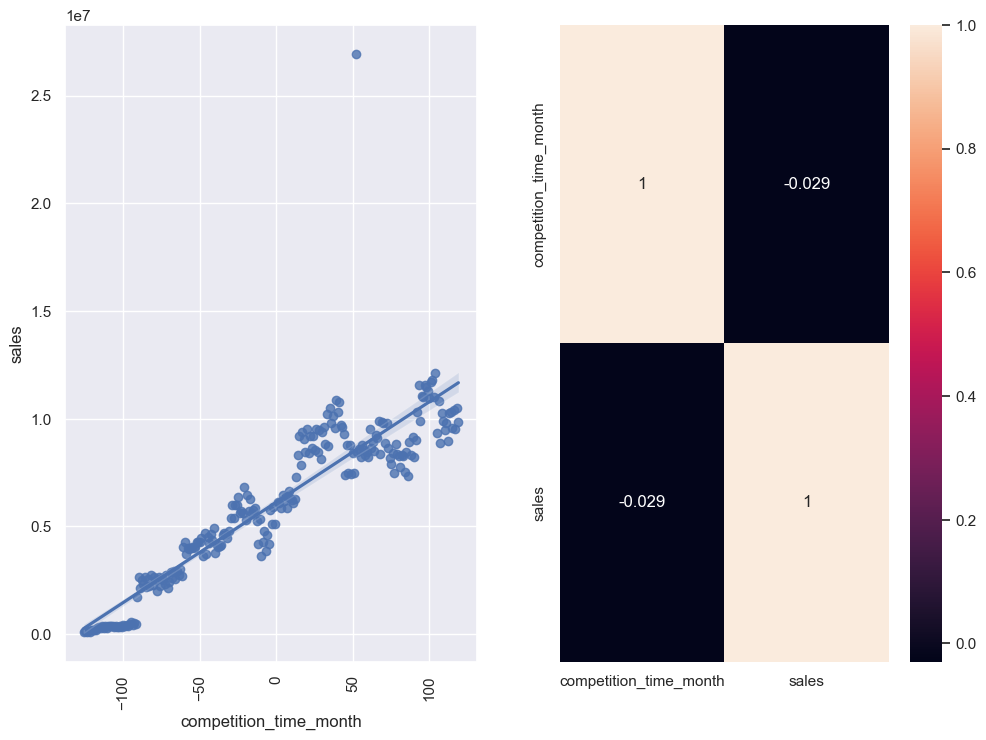

In [34]:
plt.subplot(1, 2, 1)
sns.regplot(data=h3_1, x='competition_time_month', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.heatmap(h3[['competition_time_month', 'sales']].corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

- ***FALSA:*** Lojas com promoções ativas a mais tempo, vendem menos, após certo período de promoção.


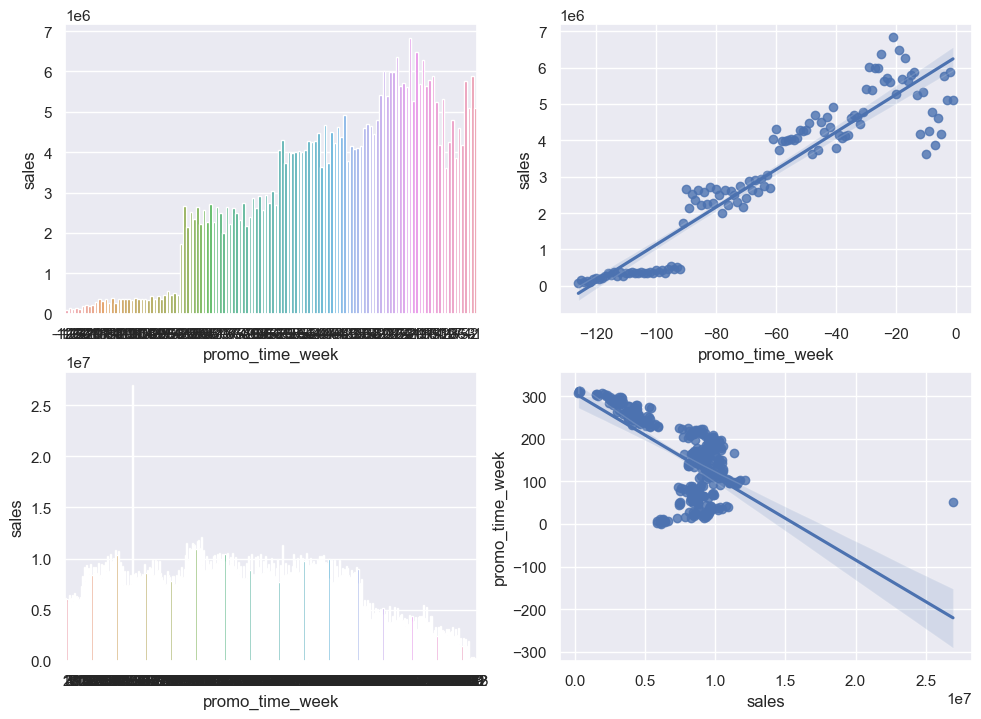

In [36]:
h4 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 2, 1)
h4_2 = h4[h4['promo_time_week'] < 0]
sns.barplot(data = h4_2, x='promo_time_week', y='sales')

plt.subplot(2, 2, 2)
sns.regplot(data = h4_2, x='promo_time_week', y='sales')

plt.subplot(2, 2, 3)
h4_3 = h4[h4['promo_time_week'] > 0]
sns.barplot(data = h4_3, x='promo_time_week', y='sales')


plt.subplot(2, 2, 4)
sns.regplot(data = h4_3, y= 'promo_time_week', x='sales');

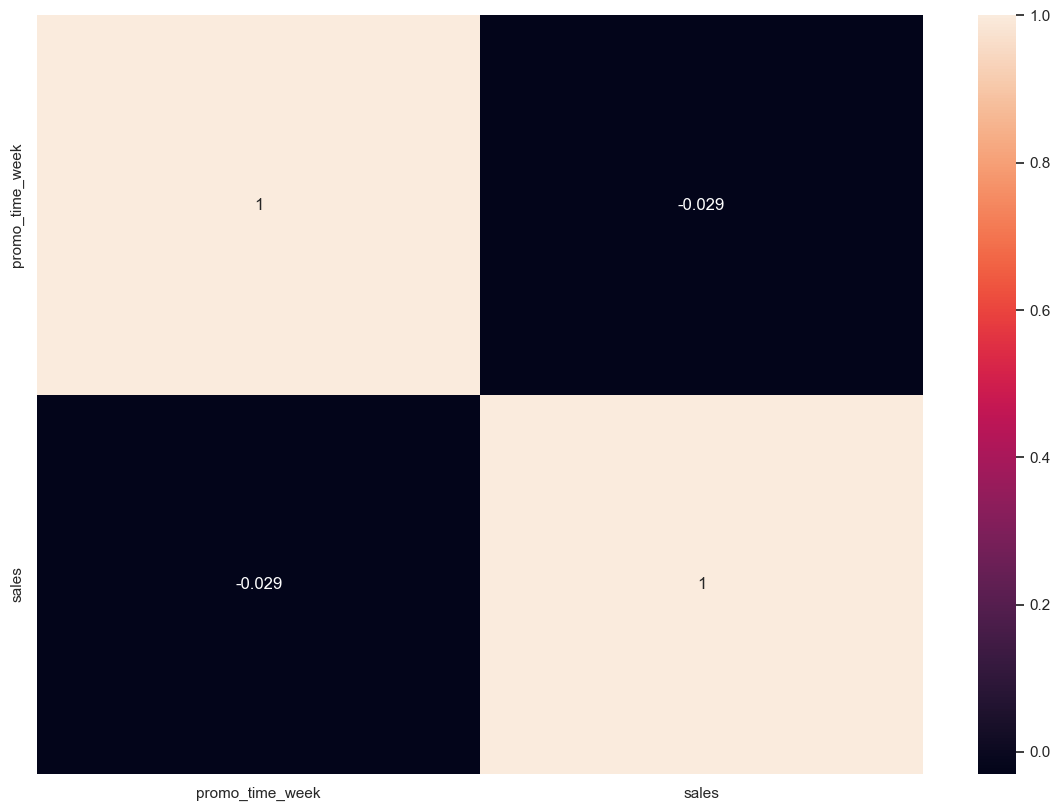

In [37]:
sns.heatmap(h4[['promo_time_week', 'sales']].corr(method='pearson'), annot=True)
plt.tight_layout();


### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

- ***FALSA**: Lojas com mais promoções consecutivas vendem menos

In [37]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


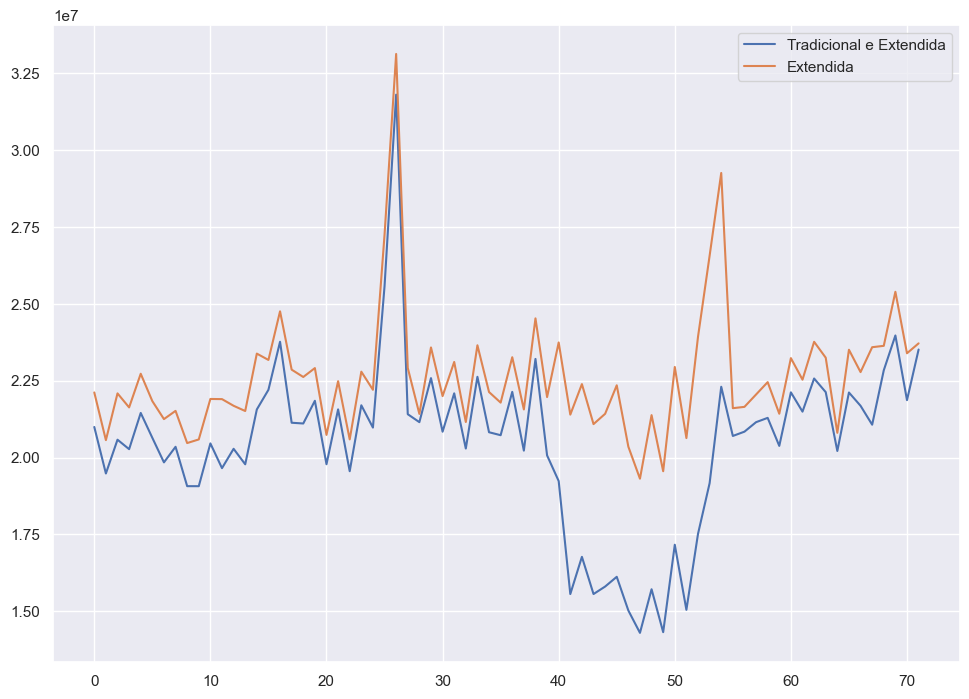

In [38]:
h4 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
h4 = h4.plot()

h4_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
h4_2.plot(ax=h4)

h4.legend(labels=['Tradicional e Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais que os outros feriados juntos

- ***FALSA:*** Lojas abertas no nata vendem menos.


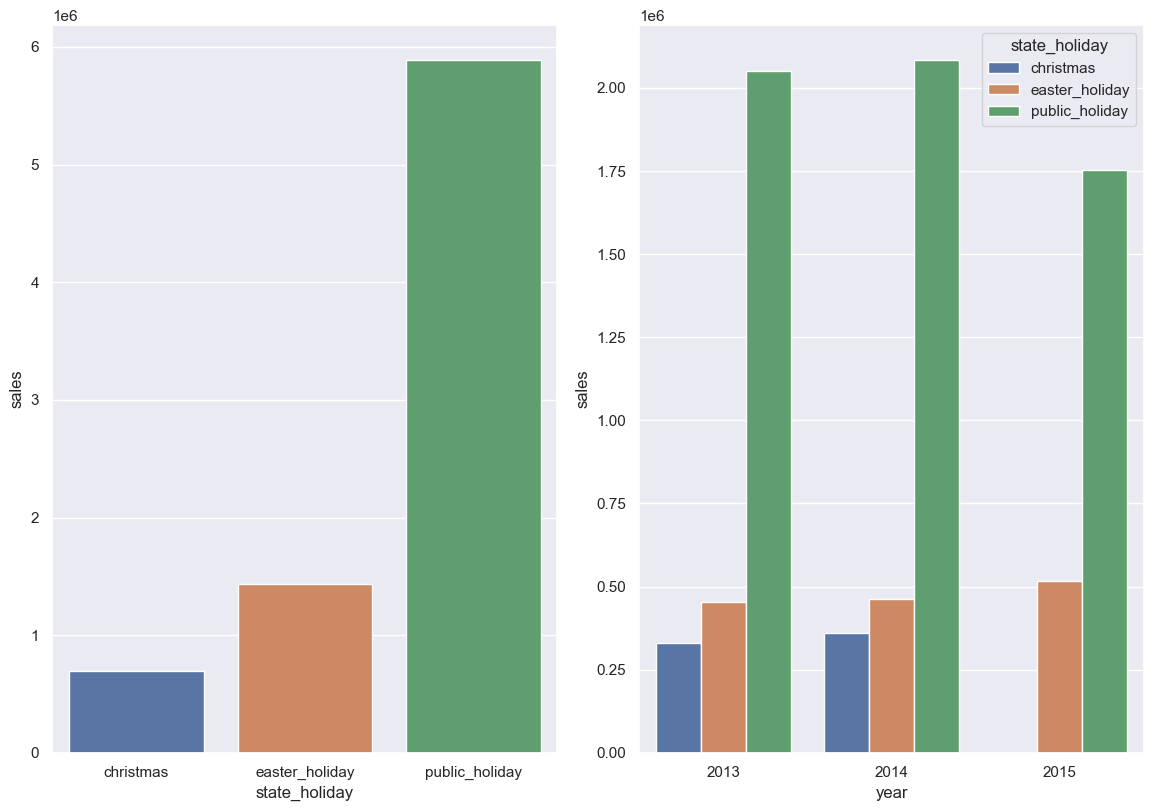

In [39]:
h7 = df4[df4['state_holiday'] != 'regular']

plt.subplot(1, 2, 1)
h7_1 = h7[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = h7_1, x='state_holiday', y='sales')
plt.tight_layout()

plt.subplot(1, 2, 2)
h7_2 = h7[['state_holiday', 'sales', 'year']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(data = h7_2, x='year', y='sales', hue='state_holiday')
plt.tight_layout();

### H8. Lojas deveriam vender mais ao longo dos anos.

- ***FALSA:*** Lojas vendem menos ao longo dos anos


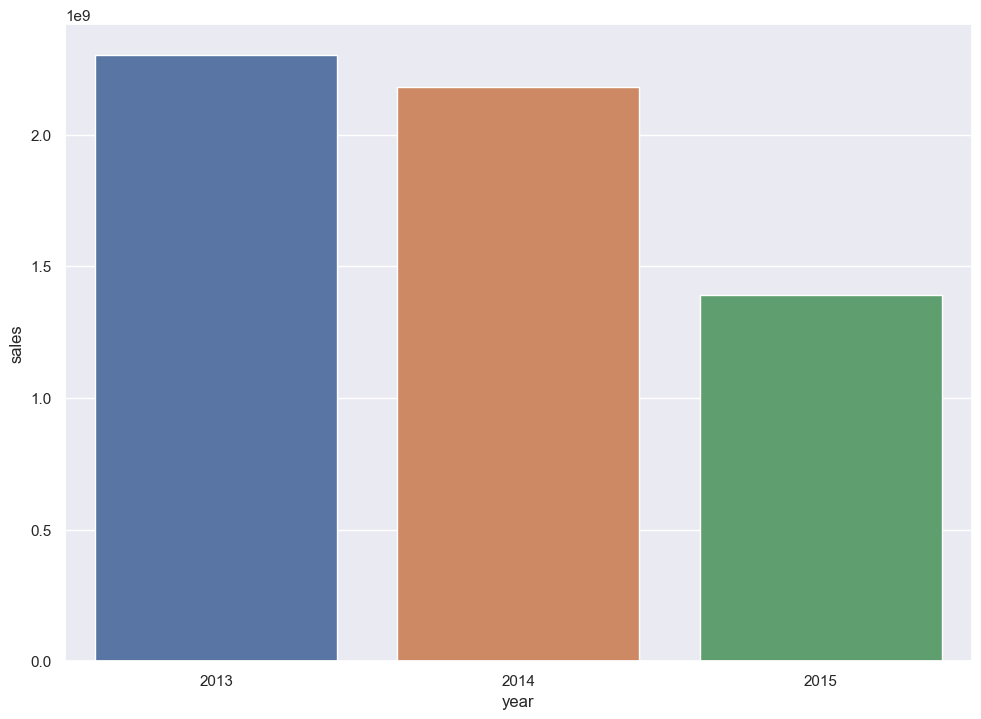

In [40]:
h8 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(data=h8, x='year', y='sales');

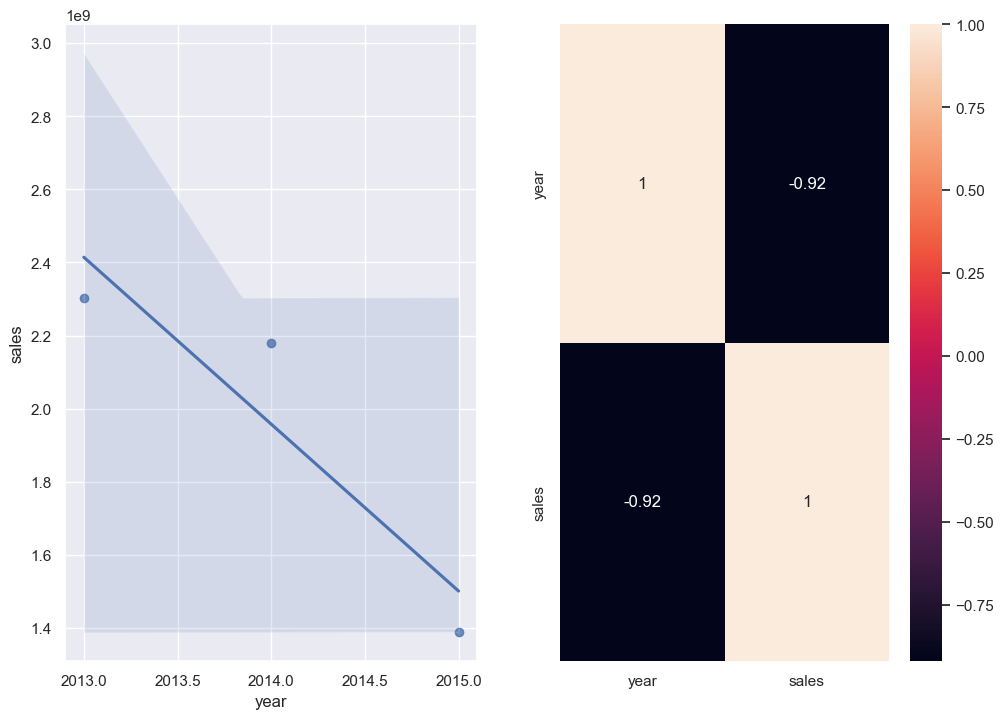

In [41]:
plt.subplot(1, 2, 1)
sns.regplot(data=h8, x='year', y='sales')


plt.subplot(1, 2, 2)
sns.heatmap(h8.corr(method='pearson'), annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.

- ***FALSE:*** Lojas vendem menos no segundo semestre do ano


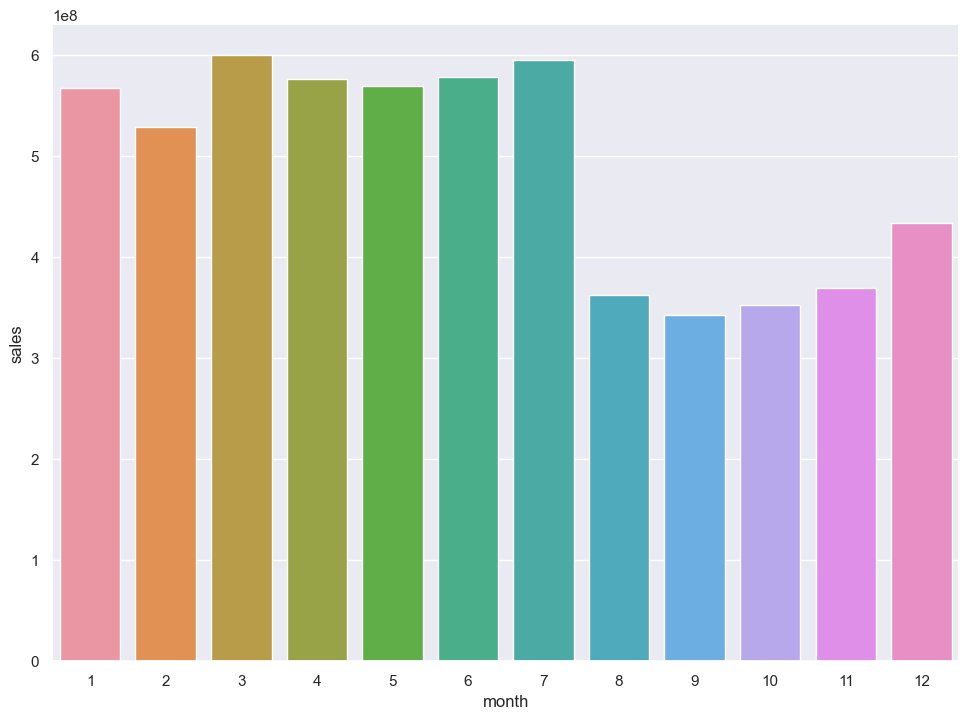

In [42]:
h9 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(data=h9, x='month', y='sales');

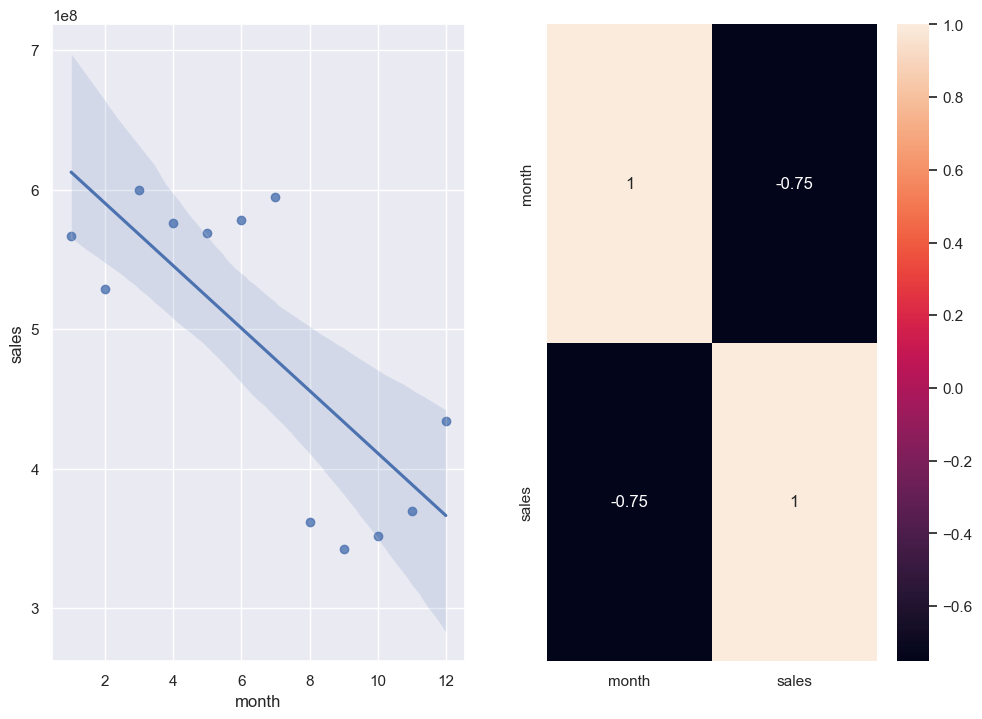

In [43]:
plt.subplot(1, 2, 1)
sns.regplot(data=h9, x='month', y='sales')


plt.subplot(1, 2, 2)
sns.heatmap(h9.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

- ***VERDADEIRA:*** Lojas vendem mais após o dia 10 de cada mês


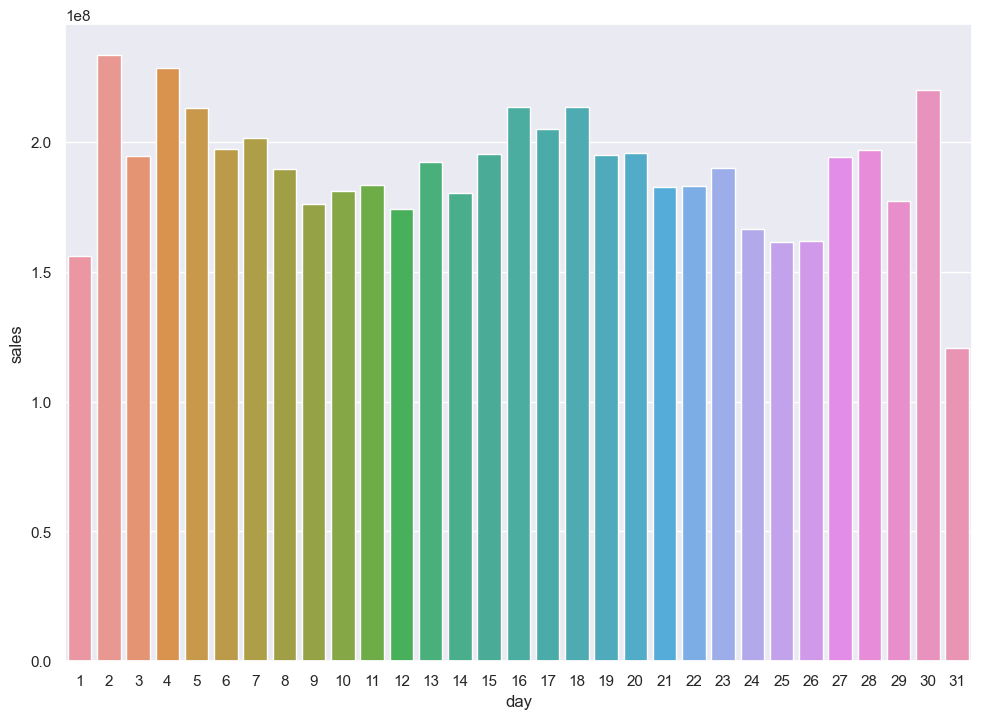

In [44]:
h10 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(data=h10, x='day', y='sales');

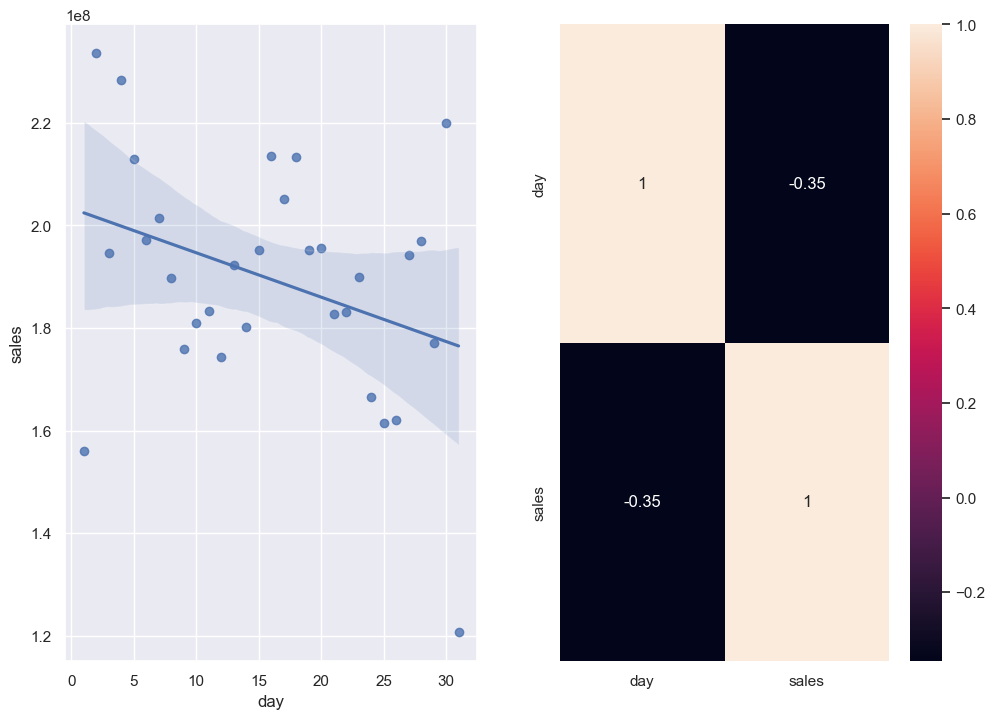

In [45]:
plt.subplot(1, 2, 1)
sns.regplot(data=h10, x='day', y='sales')

plt.subplot(1, 2, 2)
sns.heatmap(h10.corr(method='pearson'), annot=True);

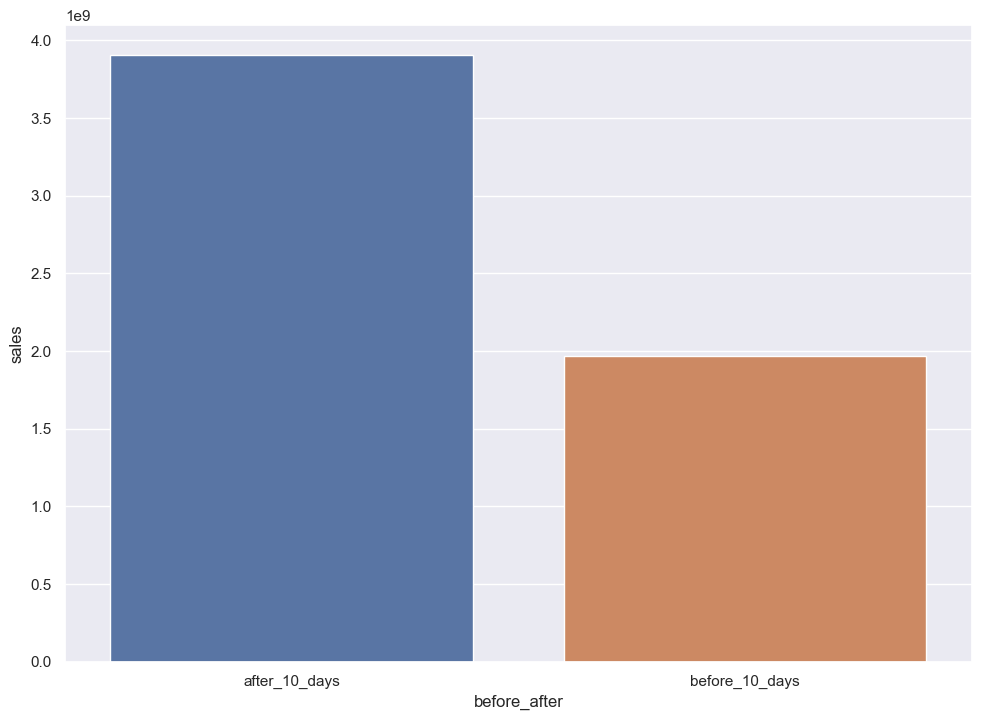

In [46]:
h10['before_after'] = h10['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

h10_2 = h10[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=h10_2, x='before_after', y='sales');

### H11. Lojas deveriam vender mais aos finais de semana

- ***FALSA:*** Lojas vendem menos aos finais de semana

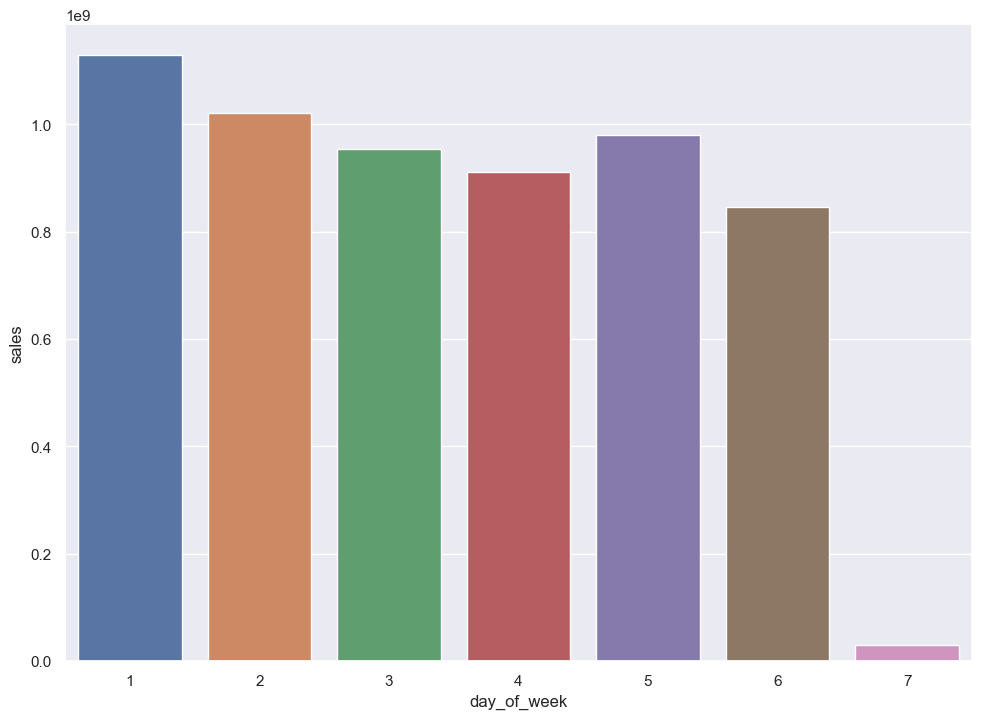

In [47]:
h11 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(data=h11, x='day_of_week', y='sales');

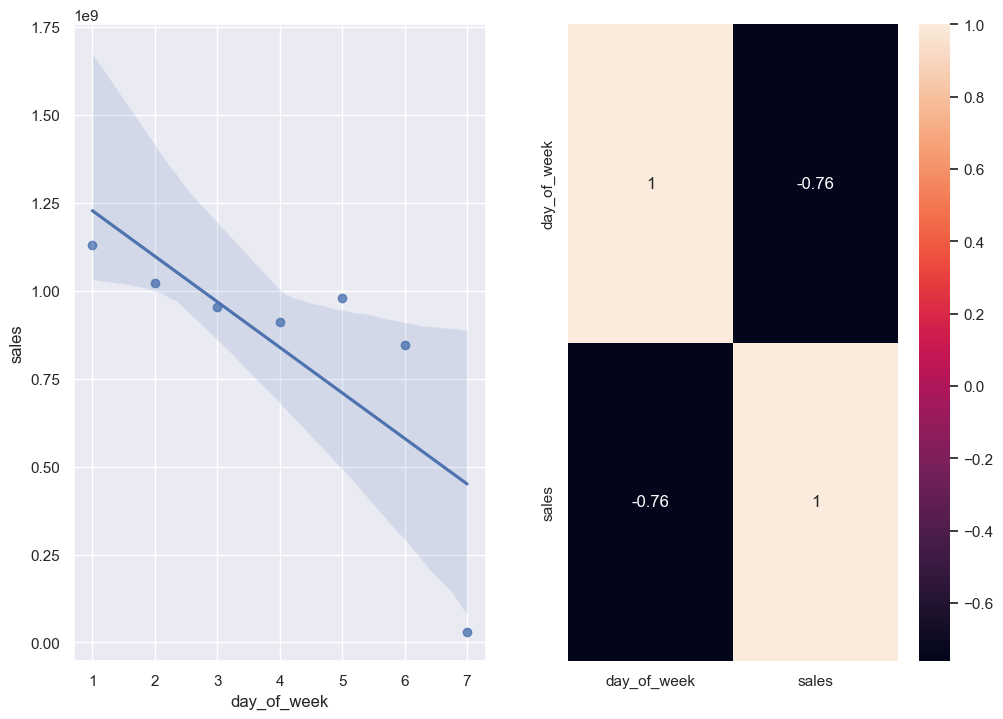

In [48]:
plt.subplot(1, 2, 1)
sns.regplot(data=h11, x='day_of_week', y='sales')

plt.subplot(1, 2, 2)
sns.heatmap(h11.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares

- ***VERDADEIRA:*** Lojas vendem menos em feriados escolares

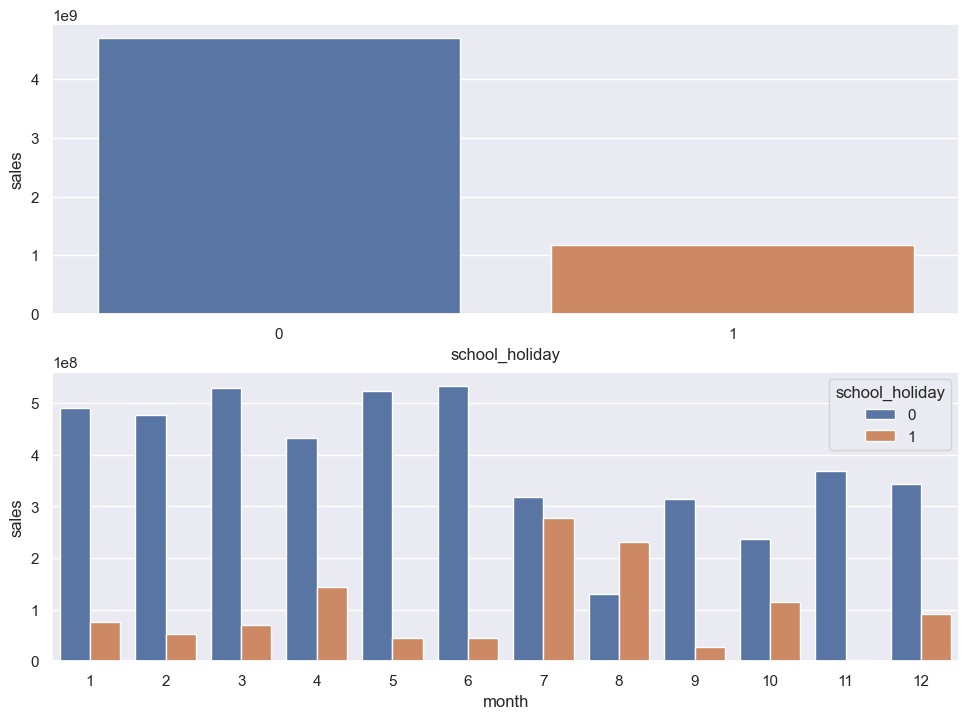

In [48]:
h12 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(data=h12, x='school_holiday', y='sales')

plt.subplot(2, 1, 2)
h12_1 = df4[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(data = h12_1, x='month', y='sales', hue='school_holiday');

## 4.3 Análise Multivariada

### 4.3.1 - Numerical Atributes

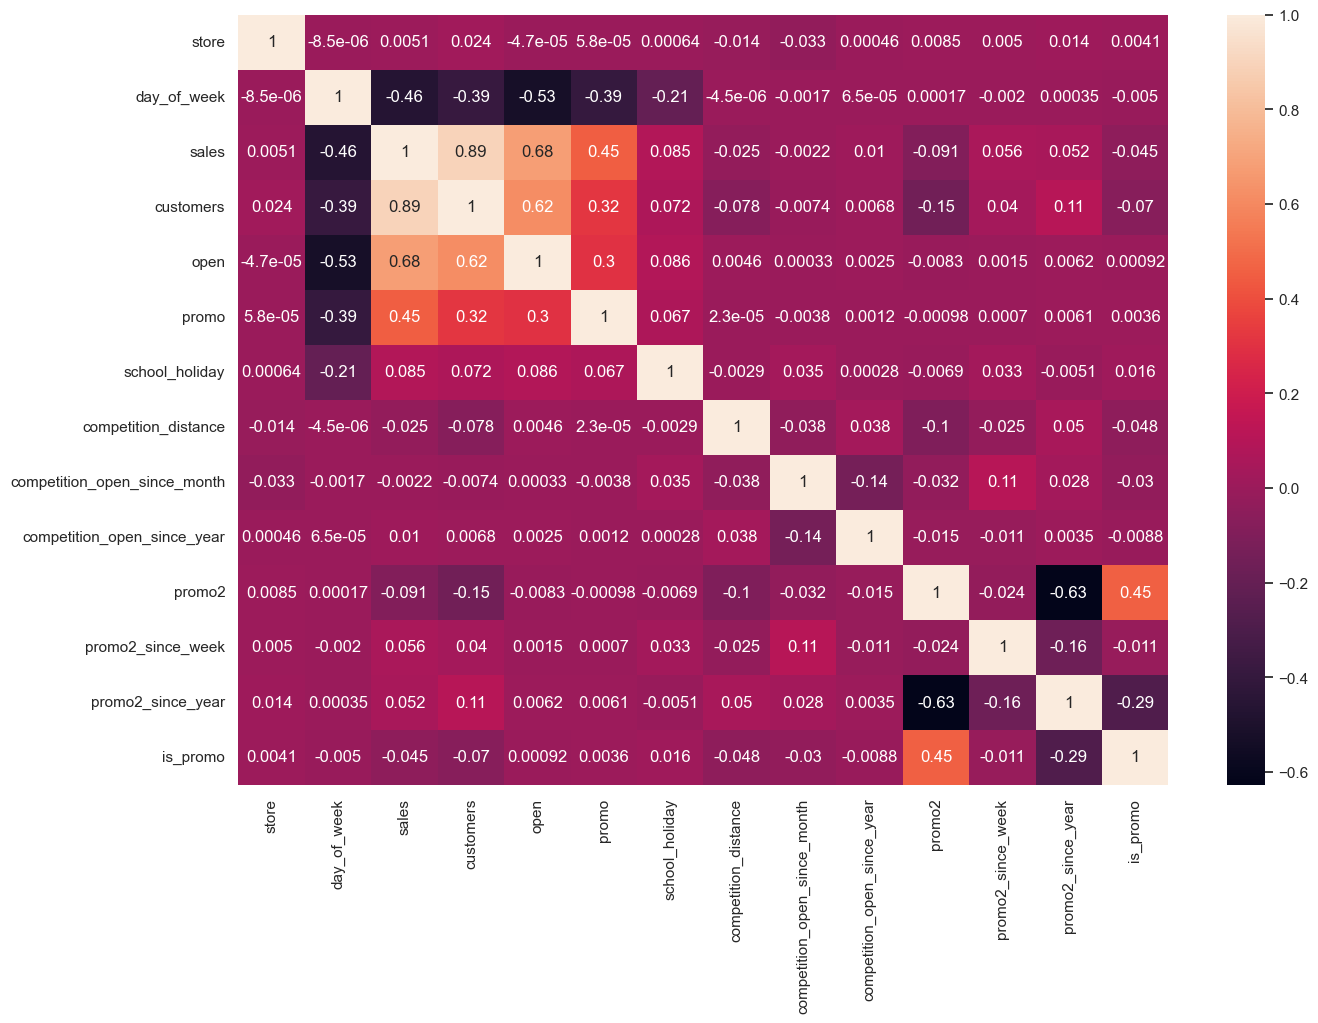

In [49]:
correlation = num_attributes.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlation, annot=True);

### 4.3.1 - Categorical Atributes

<Axes: >

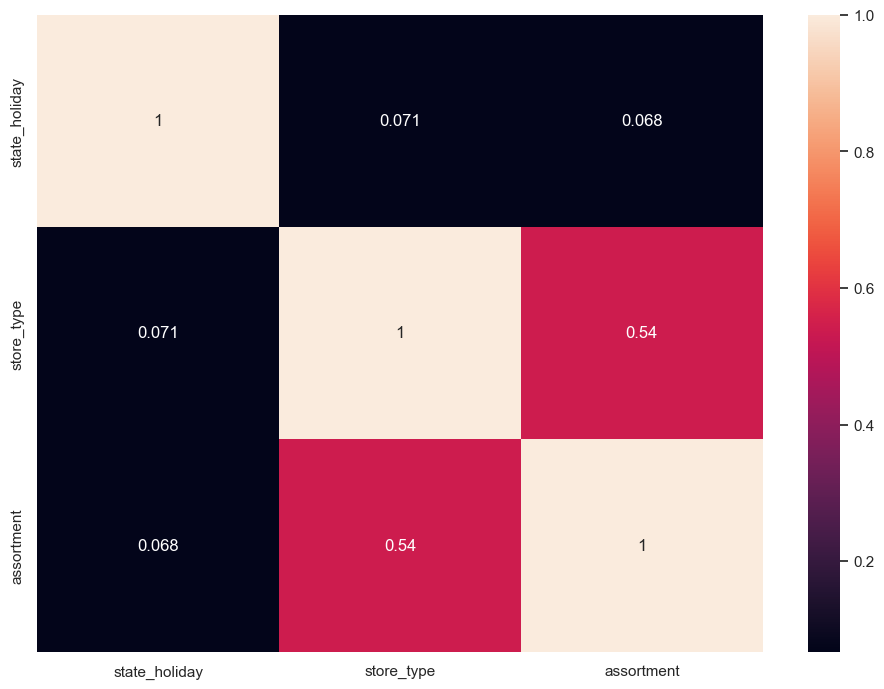

In [50]:
cat = df4.select_dtypes(include=['object'])
cat_list = ['state_holiday', 'store_type', 'assortment']
cat_dic = {}


for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2])

        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)

        else:
            cat_dic[c1].append(v)


cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)


sns.heatmap(cramer_v_table, annot=True)

# 5.0 Preparação dos  Dados

In [16]:
df5 = df4.copy()

## 5.1 Rescaling

In [17]:
num_scaling = df5.select_dtypes(include=['int32', 'int64', 'float64'])

In [18]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_rscaler.pkl', 'wb' ) )


#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_rscaler.pkl', 'wb' ) )


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open( 'parameter/promo_time_week_mmscaler.pkl', 'wb' ) )

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_mmscaler.pkl', 'wb' ) )


## 5.2 Transformação

### 5.2.1 - Encoding

In [19]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open('parameter/store_type_encoding.pkl', 'wb') )

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.2.2 - Response Variable Transformation

In [20]:
df5['sales'] = np.log1p(df5['sales'])

### 5.2.3 Nature Transformation

In [21]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30 ) ) )


#week_of_year
df5['week_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52 ) ) )
df5['week_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52 ) ) )


#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7 ) ) )


# 6.0 Feature Selection

In [53]:
df6 = df5.copy()

## 6.1 - Split dataframe into training and  test dataset

In [54]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [55]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']


# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [61]:
# Define Random Forest Regressor
rf = RandomForestRegressor ( n_jobs=-1 )

# define Boruta
boruta_selector = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 )

boruta_selector.fit(np.array(X_train), np.array(y_train))

In [62]:
cols_selected = boruta_selector.support_.tolist()

best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

## 6.3 - Manual Feature Selection

In [56]:
cols_selected_boruta = ['store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2',
         'promo2_since_week',
         'promo2_since_year',
         'competition_time_month',
         'promo_time_week',
         'month_sin',
         'month_cos',
         'day_sin',
         'day_cos',
         'week_cos',
         'week_sin',
         'day_of_week_sin',
         'day_of_week_cos']

# columns to add

feat_to_add = ['date', 'sales']

cols_boruta_full = cols_selected_boruta.copy()
cols_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [57]:
df7 = df6.copy()

In [58]:
x_train = X_train[ cols_boruta_full ]
x_test_ = X_test[ cols_boruta_full ]

# Time Series Data Preparation
x_training = X_train[ cols_boruta_full ]

In [59]:
X_train = x_train.drop(['sales', 'date'], axis=1)
X_test = x_test_.drop(['sales', 'date'], axis=1)

## 7.1 Average Model

In [29]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns= { 'sales':'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Liner Regression Model

In [30]:
#model 
lr = LinearRegression().fit( X_train, y_train )

#prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.258022,0.292732,2671.35686


## 7.2.1 Liner Regression Model - Cross Validation

In [31]:
lr_cv = cross_validation( x_training, 5, 'Linear Regression', lr)
lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.76 +/- 295.63,0.3 +/- 0.02,2952.55 +/- 468.31


## 7.3 Random Forest Regression

In [32]:
#model 
rf = RandomForestRegressor( n_estimators=1 )
rf.fit( X_train, y_train)

#prediction
yhat_rf = rf.predict( X_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,954.669799,0.141318,1430.227987


## 7.3.1 Random Forest Regression - Cross Validation

In [33]:
rf_cv = cross_validation(x_training, 5, 'Random Forest', rf)
rf_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,1180.6 +/- 288.75,0.17 +/- 0.03,1813.64 +/- 469.72


## 7.4 XGBoost Regressor

In [35]:
#model 
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=5,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9).fit( X_train, y_train)

#prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6993.691895,0.999751,7627.426196


## 7.4.1 XGBoost Regressor - Cross Validation

In [36]:
xgb_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7363.04 +/- 598.94,1.0 +/- 0.0,8015.55 +/- 698.47


## 7.5 Compare Model's Performance

In [37]:
modelling_result = pd.concat( [baseline_result, lr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,996.104140,0.148878,1507.373292
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.258022,0.292732,2671.356860
0,XGBoost Regressor,6993.691895,0.999751,7627.426196


## 7.6.1 Compare Model's Performance - Cross Validation

In [38]:
modelling_result = pd.concat( [lr_cv, rf_cv, xgb_cv] )
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,1175.01 +/- 305.56,0.16 +/- 0.03,1789.24 +/- 508.95
0,Linear Regression,2081.76 +/- 295.63,0.3 +/- 0.02,2952.55 +/- 468.31
0,XGBoost Regressor,7363.04 +/- 598.94,1.0 +/- 0.0,8015.55 +/- 698.47


# 8.0 Hiperparameter Fine Tuning

## 8.1 Grid Search

In [68]:
# define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# perform a grid search over the hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# get the best hyperparameters and evaluate the model
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

## 8.2 Random Search

In [69]:
param_dist = {'n_estimators': [10, 50, 100, 500, 1000],'max_features': ['sqrt', 'log2'],
              'max_depth': [None, 10, 50, 100],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}


rf = RandomForestRegressor()
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
final_rf = RandomForestRegressor(**best_params)
final_rf.fit(X_train,y_train)

In [50]:
best_params = {'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100}

## 8.3 Final Model

In [34]:
#model 
rf_tuned = RandomForestRegressor(n_estimators=10, max_depth=10, 
                                 min_samples_split=2, min_samples_leaf=1, random_state=42)
rf_tuned.fit( X_train, y_train)

#prediction
yhat_rf_tuned = rf_tuned.predict( X_test )

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1592.836691,0.235921,2291.160509


# 9.0 Tradução e Interpretação do erro

In [35]:
cols_selected_boruta1 = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                         'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_sin','month_cos',
                         'day_sin','day_cos','week_cos','week_sin','day_of_week_sin','day_of_week_cos', 'sales', 'date']

In [36]:
df9 = df7[cols_selected_boruta1]

In [60]:
df9 = x_test_[cols_selected_boruta1]

In [61]:
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_rf_tuned )

## 9.1 Business Performance

In [62]:
# sum of predicitions
df9_1 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAP
df9_mae = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions' ] ) ).reset_index().rename(columns={0:'MAE'})
df9_mape = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions' ] ) ).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux = pd.merge(df9_mae, df9_mape, how='inner', on='store')
df9_2 = pd.merge(df9_1, df9_aux, how='inner', on='store')

# scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# order columns
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [63]:
df9_2.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
472,473,264533.434427,260663.125389,268403.743466,3870.309039,1.262989
969,970,201040.237847,198387.474662,203693.001032,2652.763185,1.169729
306,307,206462.257240,203524.520557,209399.993922,2937.736682,1.167043
793,794,251003.759948,247488.550220,254518.969677,3515.209728,1.085899
542,543,199151.986568,196416.635580,201887.337556,2735.350988,1.079594


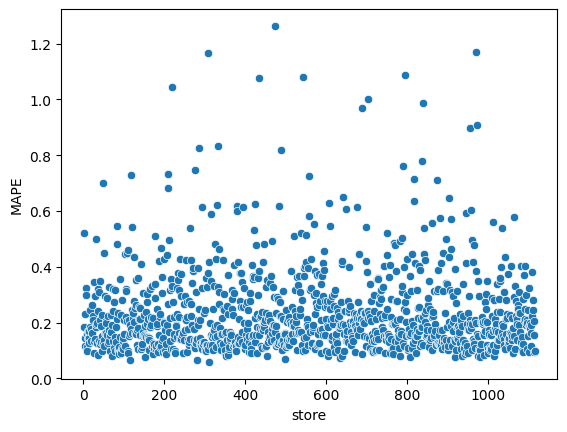

In [64]:
sns.scatterplot( x='store', y='MAPE', data=df9_2 );

## 9.2 Total Performance

In [65]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df9_3['Values'] = df9_3['Values'].map( 'R${:,.2f}'.format )
df9_3

,Scenario,Values
0,predictions,"R$270,051,371.25"
1,worst_scenario,"R$268,274,009.83"
2,best_scenario,"R$271,828,732.66"


## 9.3 Machine Learning Performance

In [66]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [67]:
df9['date'] = df6['date']

In [68]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,day_cos,week_cos,week_sin,day_of_week_sin,day_of_week_cos,sales,date,predictions,error,error_rate
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,5263.0,2015-07-31,7675.159464,-2412.159464,1.458324
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,6064.0,2015-07-31,7031.905747,-967.905747,1.159615
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,8314.0,2015-07-31,7658.365801,655.634199,0.921141
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,13995.0,2015-07-31,8441.399650,5553.600350,0.603173
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,4822.0,2015-07-31,6483.518353,-1661.518353,1.344570


## 9.4 Tradução e Interpretação do erro

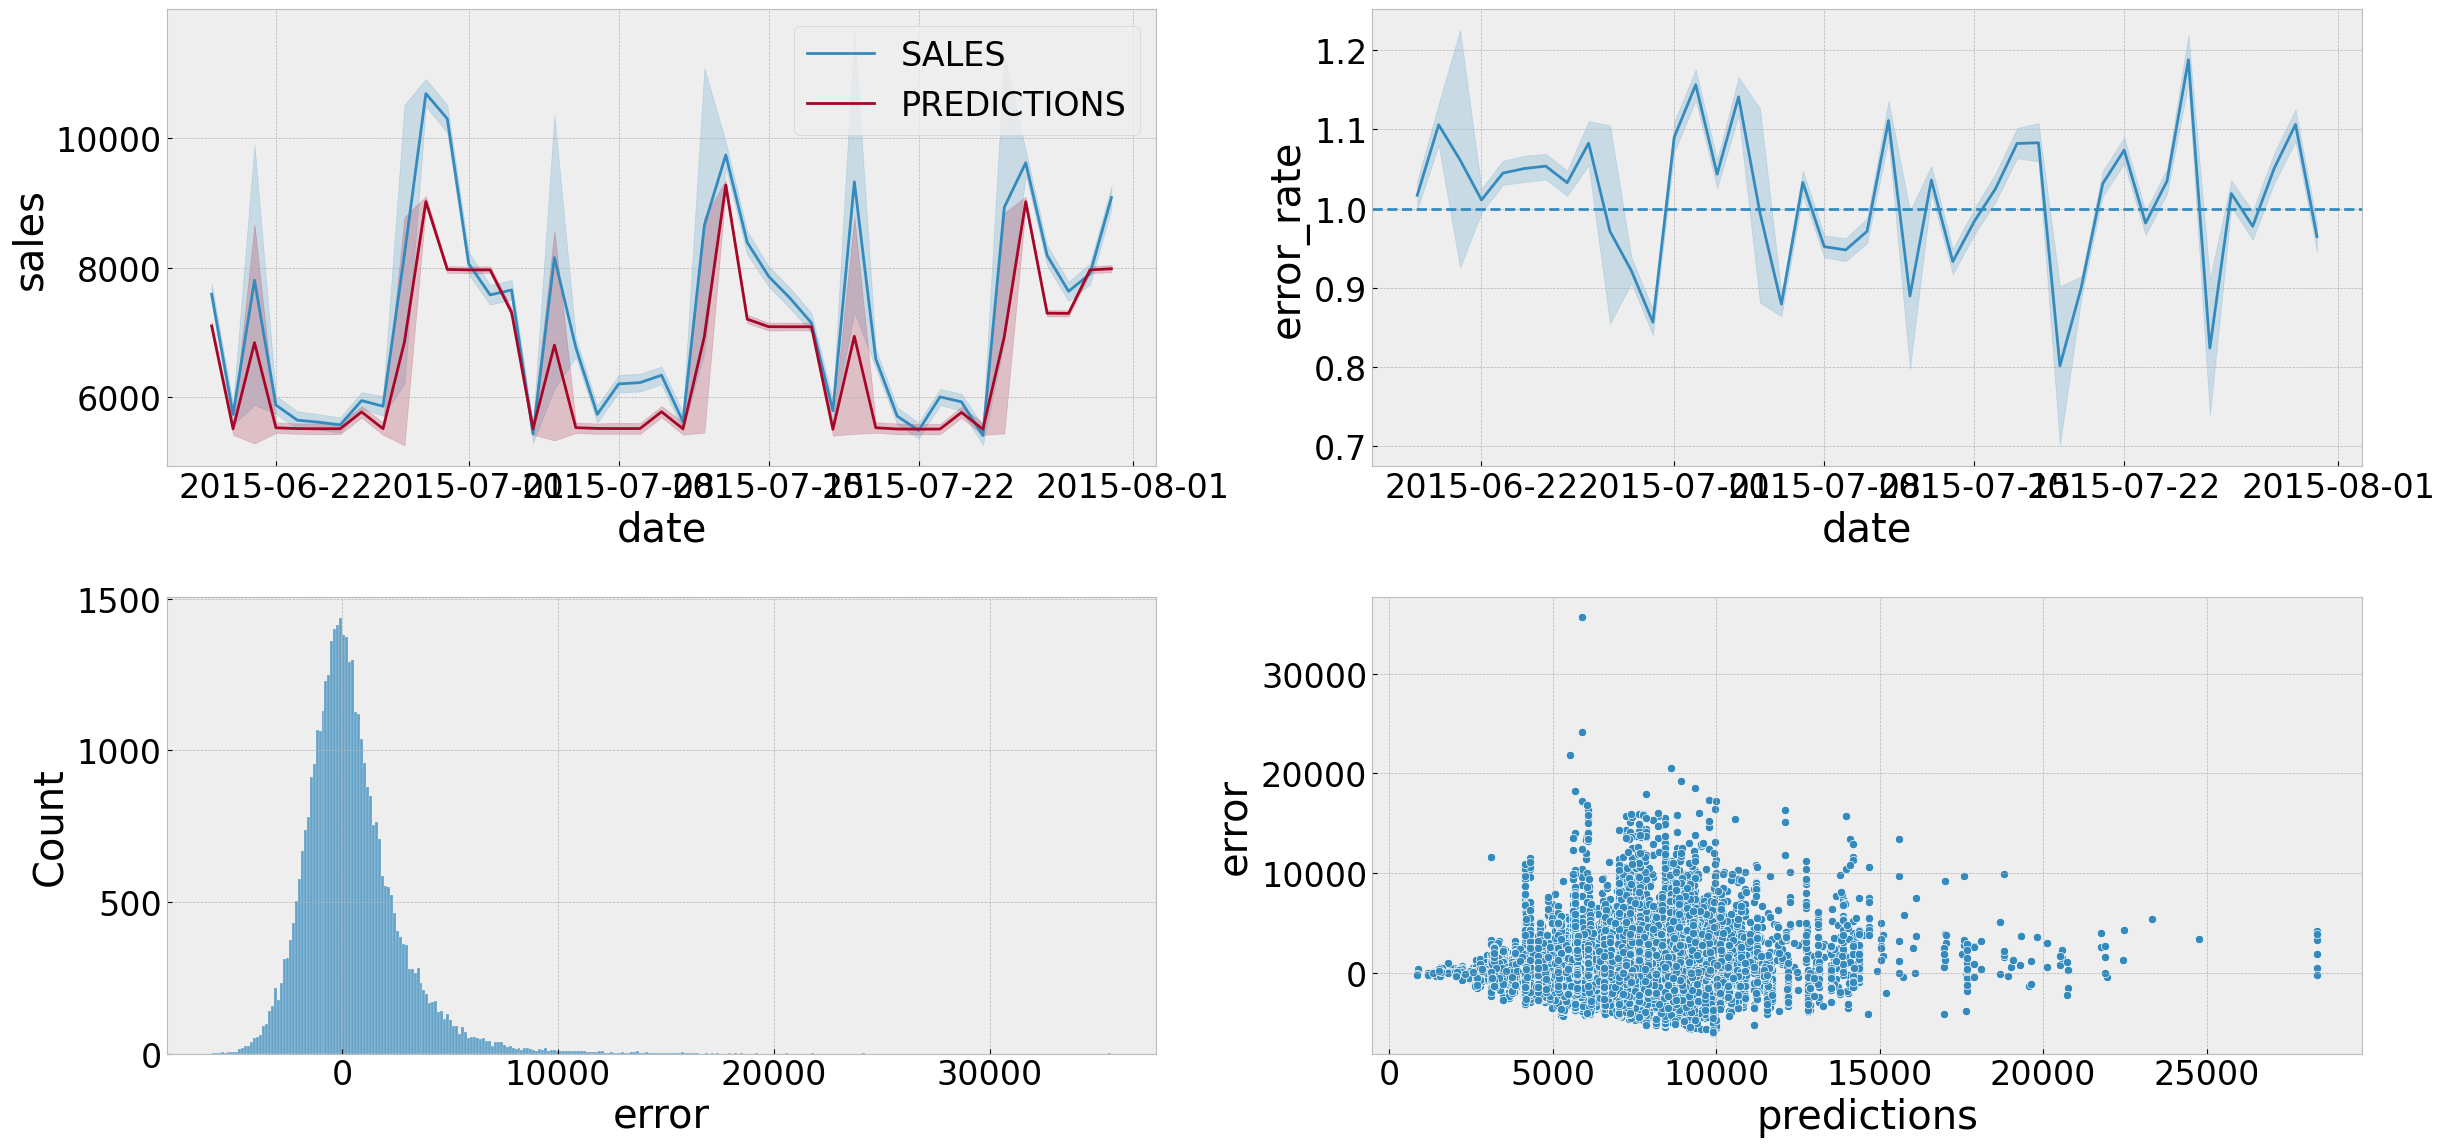

In [78]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(data=df9, x=df9['predictions'], y=df9['error'])
plt.tight_layout()

# 10.0 Models Deploy

In [43]:
#save trained model
pickle.dump( rf, open ('C:/Users/anderson.bonifacio_i/Desktop/Dados/cds/ds_producao/model/model_rossmann.pkl', 'wb') )

## 10.1 Rossman Class

In [19]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossman (object):
    def __init__(self):
        self.home_path = 'C:/Users/anderson.bonifacio_i/Desktop/Dados/cds/ds_producao/'
        self.competition_distance_scaler =   pickle.load( open( self.home_path + 'parameter/competition_distance_rscaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_rscaler.pkl', 'rb' ) )
        self.promo_time_week_scaler =        pickle.load( open( self.home_path + 'parameter/promo_time_week_mmscaler.pkl', 'rb' ) )
        self.year_scaler =                   pickle.load( open( self.home_path + 'parameter/year_mmscaler.pkl', 'rb' ) )
        self.store_type_encoding =           pickle.load( open( self.home_path + 'parameter/store_type_encoding.pkl', 'rb') )

        
        
        
    def data_cleaning( self, df1 ):
       

        ## 1.1 Rename Columns

        cols = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
                'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
                'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols))

        df1.columns = cols_new



        #alterando a colunda data de object para tipo data

        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5 Fillout NA

        #competition_distance  

        df1['competition_distance'] = (df1['competition_distance'].
                                       apply(lambda x: 200000.0 if math.isnan(x) else (x)))


        #competition_open_since_month
        df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].
                                                         month if math.isnan(x['competition_open_since_month'])
                                                         else x['competition_open_since_month'], axis=1))

        #competition_open_since_year
        df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].
                                                         year if math.isnan(x['competition_open_since_year'])
                                                         else x['competition_open_since_year'], axis=1))

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                       else x['promo2_since_week'], axis=1)


        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                       else x['promo2_since_year'], axis=1)

        #promo_interval

        month_map = { 1: 'Jan', 2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May', 6: 'Jun',  
                     7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct',  11: 'Nov',  12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = (df1[['promo_interval', 'month_map']].
                           apply(lambda x: 0 if x['promo_interval'] == 0 
                                 else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                 else 0, axis=1))


        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    
    def feature_engineering (self, df2):
        
        # year 
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = (df2.apply(lambda x: datetime.datetime
                                              (year=x['competition_open_since_year'],
                                               month=x['competition_open_since_month'],
                                               day=1), axis=1))


        #df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int))

        df2['competition_time_month'] = (df2['date'] - df2['competition_since']).apply(lambda x: (x.days)/30).astype(int)




        # promo since

        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = (df2['promo_since'].
                              apply(lambda x: datetime.datetime.
                                    strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)))


        df2['promo_time_week'] = df2['competition_time_month'] = (((df2['date'] - df2['promo_since']) / 7).
                                         apply(lambda x: x.days).astype(int))



        # assortment



        df2['assortment'] = (df2['assortment'].
                             apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended'))

        # state_holiday

        df2['state_holiday'] = (df2['state_holiday'].
                             apply(lambda x: 'public_holiday' if x == 'a' 
                                   else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' 
                                   else 'regular'))



        ## 3.1 Filtragem das Linhas

        df2 = df2[df2['open'] != 0 ]



        ## 3.2 Seleção das Colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2


    
    def data_preparation (self, df5):
        

        #competition_distance
        df5['competition_distance'] =   self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        #promo_time_week
        df5['promo_time_week'] =        self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        #year
        df5['year'] =                   self.year_scaler.transform(df5[['year']].values)
        


        ### 5.3.1 - Encoding

        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoding
        
        df5['store_type'] = self.store_type_encoding.transform( df5['store_type'] )
        

        #assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.3 Nature Transformation

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12 ) ) )

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30 ) ) )


        #week_of_year
        df5['week_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52 ) ) )
        df5['week_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52 ) ) )


        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7 ) ) )
        
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance',
                                'competition_open_since_month','competition_open_since_year','promo2','promo2_since_week',
                                'promo2_since_year','competition_time_month','promo_time_week','month_sin','month_cos','day_sin',
                                'day_cos','week_cos','week_sin','day_of_week_sin','day_of_week_cos']
        
        return df5[cols_selected]


    def get_predictions(self, model, original_data, test_data):
        #prediction
        
        pred = model.predict( test_data )
        
        # join pred into original data
        original_data['predictions'] = np.expm1( pred )
        
        return original_data.to_json (orient='records', date_format='iso')


## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model

model = pickle.load( open( 'C:/Users/anderson.bonifacio_i/Desktop/Dados/cds/ds_producao/model/model_rossmann.pkl', 'rb') )

app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )



def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance ( test_json, dict): #unique example
            test_raw = pd.DataFrame( test_json, index[0])
        
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
            
        # instanciate Rossmann Class
        
        pipeline = Rossmann()
        
        # data cleaning
        
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        
        df2 = pipeline.feature_engineering (df1)
        
        # data preparation
        
        df3 = pipeline.data_preparation( df2 )
        
        # predictions
        
        df_response = pipeline.get_predictions( model, test_raw, df3)
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run('192.168.15.7')
    

## 10.3 API Tester

In [26]:
df10 = pd.read_csv( 'data/test.csv')

In [27]:
df_teste = pd.merge( df10, df_store_raw, how='left', on='Store')

df_teste = df_teste[df_teste['Store'] == 15 ]

df_teste = df_teste[df_teste['Open'] != 0 ]
df_teste = df_teste[~df_teste['Open'].isnull()]
df_teste = df_teste.drop( 'Id', axis =1)

In [28]:
# Convert dataframe to json

data = json.dumps(df_teste.to_dict(orient='records'))

In [29]:
# API Call
url = 'https://rossmann-predicition.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [30]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [46]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,predictions
0,22,4,2015-09-17T00:00:00.000,1.0,1,regular,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,173,2012-05-21T00:00:00.000,173,4903.393360
1,22,3,2015-09-16T00:00:00.000,1.0,1,regular,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,173,2012-05-21T00:00:00.000,173,5158.190024
2,22,2,2015-09-15T00:00:00.000,1.0,1,regular,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,15,38,2015-37,2015-09-01T00:00:00.000,173,2012-05-21T00:00:00.000,173,5614.050513
3,22,1,2015-09-14T00:00:00.000,1.0,1,regular,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,14,38,2015-37,2015-09-01T00:00:00.000,173,2012-05-21T00:00:00.000,173,6657.760384
4,22,6,2015-09-12T00:00:00.000,1.0,0,regular,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,12,37,2015-36,2015-09-01T00:00:00.000,172,2012-05-21T00:00:00.000,172,3267.352708


In [31]:
d2 = d1[['store', 'predictions']].groupby('store').sum().reset_index()

In [32]:
for i in range ( len ( d2 ) ):
    print( 'Store Number {} will sell ${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'predictions']))

Store Number 15 will sell $289,835.00 in the next 6 weeks
